<center><h1 class="background-title">Workshop 12 - Background<br>AdaBoost</h1></center>

## AdaBoost

AdaBoost (Adaptive Boosting) is a technique for improving the performance of a given classification algorithm by taking a smart weighted sum of multiple instances of the classifier.

This technique is based on iteratively building the series of classifier while keeping a vector of weights of how good was each point classified by previous classifiers. In each step the algorithm tries to build a classifier which corrects the errors made by previous classifiers.

Using the following notation:
- $N$ - Is the size of the dataset
- $\left\{\boldsymbol{x}_i,y_i\right\}$ - Are the measurements and the labels.
- The labels $\left\{y_i\right\}$ have $1,-1$ values.

the steps of this algorithm are as follow:
- Initialize a uniform weights vector for each data points: $w^{\left(t=0\right)}_i=\frac{1}{N}$
- Iterate over the following steps, with a index $t$, until reaching some stopping criteria:
  1. Build an optimal classifier $h_t$ according to the given weighted dataest.
  2. Calculate the prediction error of $h_t$ on the weighted dataset: $\varepsilon=\sum_i w^t_iI\left\{h\left(\boldsymbol{x}_i\right)\neq y_i\right\}$
  3. Calculate the the weight for the $h_t$ classifier according to: $\alpha_t=\frac{1}{2}\ln\left(\frac{1-\varepsilon}{\varepsilon}\right)$
  4. Update the weights of the data according to $w^t_i=w^{t-1}_i\exp\left(-\alpha_ty_ih_t\left(\boldsymbol{x}_i\right)\right)$
  5. Normalize the weight by $Z=\sum_iw^t_i$ according to: $w^t_i=\frac{w^t_i}{Z}$

The final prediction will then be the following linear combination of the trained classifiers:
$$
h\left(\boldsymbol{x}_i\right)=\text{sign}\left(\sum_t\alpha_th_t\left(\boldsymbol{x}_i\right)\right)
$$


<center><h1 class="workshop-title">Workshop 12<br>AdaBoost</h1></center>

## Problem:  Back to the Titanic

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/RMS_Titanic_3.jpg/1200px-RMS_Titanic_3.jpg" width=400px></center>

We will return to the problem from workshop 1 of trying to predict whether a passenger on board the Titanic has survived or not based on the data from the passengers manifest.

## Dataset: The Titanic Manifest

The full manifest data can be found [here](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.html) with some additional details  regarding the dataset.

A cleaner version of it for our needs can be found [here](https://yairomer.github.io/ml_course/datasets/titanic_manifest.csv).


## 🔃 The Workflow

We will follow the usual work follow to build our digits classifier

<center><img src="../media/diagrams/workflow/workflow_full.png" width="300px" style="width:300px"/></center>

## 🛠️ Preparations

In [ ]:
# Importing packages
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

plt.rcParams['figure.figsize'] = (5.0, 5.0)  # Set default plot's sizes
plt.rcParams['figure.dpi'] =120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## A function to add Latex (equations) to output which works also in Google Colabrtroy
## In a regular notebook this could simply be replaced with "display(Markdown(x))"
from IPython.display import HTML
def print_math(x):  # Define a function to preview markdown outputs as HTML using mathjax
    display(HTML(''.join(['<p><script type="text/x-mathjax-config">MathJax.Hub.Config({tex2jax: {inlineMath: [[\'$\',\'$\'], [\'\\\\(\',\'\\\\)\']]}});</script><script src=\'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=TeX-AMS_CHTML\'></script>',x,'</p>'])))

## 🕵️ Data Inspection

Like always, we will start by loading the data and taking a look at it by printing out the 10 first rows.

In [ ]:
data_file = 'https://yairomer.github.io/ml_course/datasets/titanic_manifest.csv'

## Loading the data
dataset = pd.read_csv(data_file)

## Print the number of rows in the data set
number_of_rows = len(dataset)
print_math('Number of rows in the dataset: $N={}$'.format(number_of_rows))

## Show the first 10 rows
dataset.head(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,numeric_sex
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1
2,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",0
3,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1
4,1,1,"Anderson, Mr. Harry",male,48,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY",0
5,1,1,"Andrews, Miss. Kornelia Theodosia",female,63,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY",1
6,1,0,"Andrews, Mr. Thomas Jr",male,39,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI",0
7,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY",1
8,1,0,"Artagaveytia, Mr. Ramon",male,71,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay",0
9,1,0,"Astor, Col. John Jacob",male,47,1,0,PC 17757,227.5250,C62 C64,C,NaN,124.0,"New York, NY",0


### The Data Fields and Types
In this workshop we will use the following fields:
- **pclass**: the ticket's class: 1st, 2nd or 3rd: 1, 2 or 3
- **sex**: the sex of the passenger as a string: male or female
- **age**: the passenger's age: an integer
- **sibsp**: the number of Siblings/Spouses aboard for each passenger: an integer
- **parch**: the number of Parents/Children aboard for each passenger: an integer
- **fare**: The price the passenger payed for the ticket: a positive real number
- **embarked**: The port in which the passenger embarked the ship: (C = Cherbourg; Q = Queenstown; S = Southampton)

- **survived**: The label for whether or not this passenger has survived: 0 or 1

(A full description for each of the other columns can be found [here](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt))

###  📉 Some Plots

Let us plot the survival of passengers as a function of each of the features.

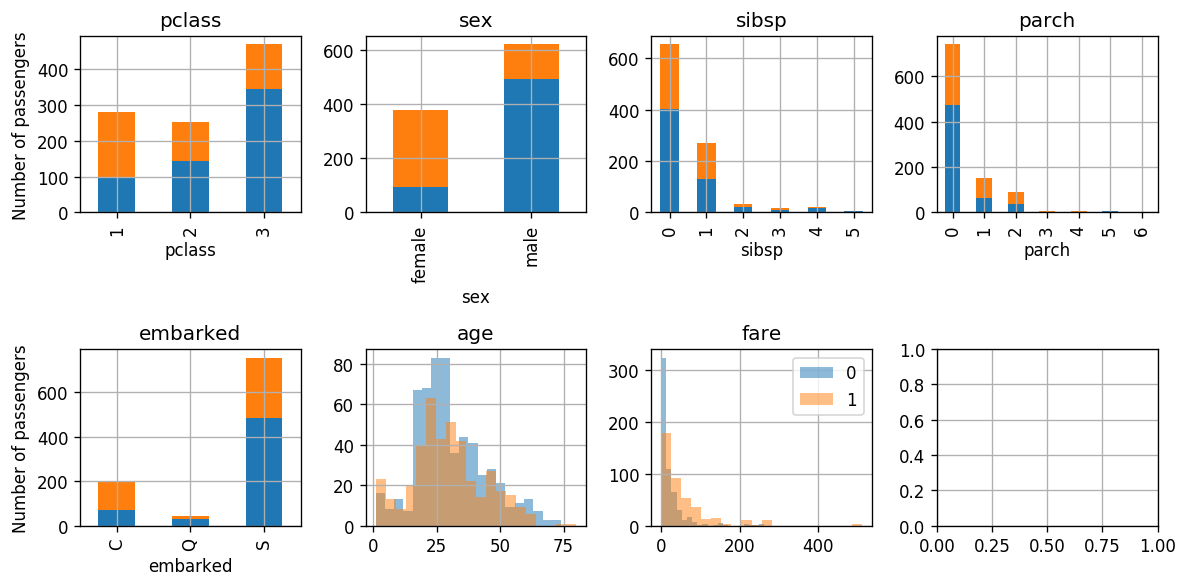

In [ ]:
discrete_columns = ['pclass', 'sex', 'sibsp', 'parch', 'embarked']
continuous_columns = ['age', 'fare']

## Plotting the histograms
fig, ax_list = plt.subplots(2, 4, figsize=(10, 5))
for i, feature in enumerate(discrete_columns):
    ax = ax_list.flat[i]
    dataset.groupby([feature, 'survived']).size().unstack('survived').plot.bar(ax=ax, stacked=True, legend=False)
    ax.set_title(feature)

for i, feature in enumerate(continuous_columns):
    ax = ax_list.flat[i + len(discrete_columns)]
    ax.hist(dataset.query('survived == 0')[feature].values, bins=20, alpha=0.5, label='0')
    ax.hist(dataset.query('survived == 1')[feature].values, bins=20, alpha=0.5, label='1')
    ax.set_title(feature)
    
for ax_list2 in ax_list:
    ax_list2[0].set_ylabel('Number of passengers')
    
ax_list.flat[-2].legend()
plt.tight_layout()

To make the dataset more useful to work with we will change all the discrete features to be numeric and start at 0 (we  will treat **sibsp** and **parch** as finite discrete features):

In [ ]:
dataset2 = pd.DataFrame({
    'survived': dataset['survived'],
    'pclass': dataset['pclass'].map({1:0, 2:1, 3:2}),
    'sex': dataset['sex'].map({'male':0, 'female':1}),
    'sibsp': dataset['sibsp'],
    'parch': dataset['parch'],
    'embarked': dataset['embarked'].map({'C':0, 'Q':1, 'S':2}),
    'age': dataset['age'],
    'fare': dataset['fare'],
    })

dataset2.dropna(axis=0, inplace=True)
dataset2['embarked'] = dataset2['embarked'].astype(int)
dataset2['weights'] = np.ones(len(dataset2)) / len(dataset2)

## 📜 Problem Definition

For the following given random system:

- Random sample: $\omega$ - A passenger on board the Titanic.
- Random variables:
  - $\boldsymbol{x}=X\left(\omega\right)$: The passenger parameters extracted from the manifest.
  - $y=Y\left(\omega\right)$: An indicator of whether or not the passenger survived.

Find a binary discrimination function $\hat{y}=h^*\left(\boldsymbol{x}\right)$ which minimizes the misclassification rate:

$$
h^*=\underset{h}{\arg\min}\ E\left[I\left\{h\left(\boldsymbol{x}\right)\neq y\right\}\right]
$$

## 💡 Model & Learning Method Suggestion: Stumps + AdaBoost

We will use Stumps classifiers (one level decision trees) which are boosted using AdaBoost. 

We will use the **weighted Gini index** to build our classifiers using the weighted data. For a given split of the data in to $\mathcal{C}_1$ and $\mathcal{C}_2$ and a set of weights $\left\{w_i\right\}$, the **weighted Gini index** will be:

$$
N_1=\sum_{i\in\mathcal{C}_1}w_i\\
N_2=\sum_{i\in\mathcal{C}_2}w_i\\
p_1=\frac{1}{N_1}\sum_{i\in\mathcal{C}_1}w_iI\left\{y_i=1\right\}\\
p_2=\frac{1}{N_2}\sum_{i\in\mathcal{C}_2}w_iI\left\{y_i=1\right\}\\
G=N_1p_1\left(1-p_1\right)+N_2p_2\left(1-p_2\right)
$$

### Parameters:

- The splitting performed by each stump.
- The weighting of the stumps. $\alpha_i$.

### Hyper-parameters

The only parameter in this case is the stopping criteria of the the AdaBoost algorithm which defines the number of Stumps.

## Data preprocessing

### 📚 Splitting the dataset

We will split the dataset into 80% train - 20% test.

In [ ]:
n_samples = len(dataset2)

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(0)

## Generating a vector of indices
indices = np.arange(n_samples)

## Shuffle the indices
rand_gen.shuffle(indices)

## Split the indices into 80% train / 20% test
n_samples_train = int(n_samples * 0.8)
n_samples_test = n_samples - n_samples_train
train_indices = indices[:n_samples_train]
test_indices = indices[n_samples_train:]

train_set = dataset2.iloc[train_indices]
test_set = dataset2.iloc[test_indices]

## ⚙️ Learning

### Implementing a single stump

In [ ]:
def calc_gini_on_split(split, y, weights):
    """
    A function for calculating the the weighted Gini index for a given split of the data.
    """
    
    ## Handle the case of a degenerated split
    if np.count_nonzero(split) == 0 or np.count_nonzero(split) == len(split):
        return np.inf
    
    ## The ratio of positive labels in branch 1
    p1 = (split * y * weights).sum() / (split * weights).sum()
    ## The ratio of positive labels in branch 2
    p2 = ((1 - split) * y * weights).sum() / ((1 - split) * weights).sum()
    ## The Gini index
    res = p1 * (1 - p1) * (split * weights).sum() + p2 * (1 - p2) * ((1 - split) * weights).sum()
    return res

class Stump:
    """
    A class for fitting and predicting a single stump
    """
    def __init__(self):
        self.split_mask = None
        self.threshold = None
        self.field = None
    
    def fit(self, dataset, field):

        self.field = field
        self.is_discrete = field in ['pclass', 'sex', 'sibsp', 'parch', 'embarked']
        
        ## Extrac relevat data for the dataset
        x = dataset[self.field].values
        y = dataset['survived'].values
        weights = dataset['weights'].values
        n_unique_vals = len(np.unique(x))
        
        if self.is_discrete:
            ## The finit discrete case
            ## A trick for generating all possible splits
            tmp = np.arange(2 ** n_unique_vals, dtype=np.uint8)
            all_possibles_splits = np.unpackbits(tmp[:, None], axis=1)[1:-1, -n_unique_vals:].astype(int)
            
            ## Loop over possible splits to look for the optimal split
            gini_min = np.inf
            for split_mask in all_possibles_splits:
                cls = split_mask[x]
                gini = calc_gini_on_split(cls, y, weights)
                if gini < gini_min:
                    gini_min = gini
                    self.split_mask = split_mask
        
        else:
            ## The continues case
            
            ## Al relevant thresholds
            all_possibles_thresholds = (x[:-1] + x[1:]) / 2
            
            ## Looping over thresholds
            gini_min = np.inf
            for threshold in all_possibles_thresholds:
                cls = x > threshold
                gini = calc_gini_on_split(cls, y, weights)
                if gini < gini_min:
                    gini_min = gini
                    self.threshold = threshold
        
        self.gini = gini_min
        
        return self
    
    def predict(self, dataset):
        x = dataset[self.field].values
        if self.is_discrete:
            y = self.split_mask[x]
        else:
            y = x > self.threshold
        
        return y
    
    def print_stump(self):
        if self.is_discrete:
            print('Classifing {} according to: {}'.format(self.field,
                                                          {0: np.where(1 - self.split_mask)[0].tolist(),
                                                           1: np.where(self.split_mask)[0].tolist()}))
        else:
            print('Classifing according to: {} > {}'.format(self.field, self.threshold))

### Implementing AdaBoost

In [ ]:
class AdaBoost:
    """
    A class which implaments the AdaBoost algorithm
    """
    def __init__(self, dataset):
        self.dataset = dataset.copy()
        self.y = self.dataset['survived'].values
        self.stumps_list = []
        self.alpha_list = []
        
        self.dataset['weights'] = np.ones(len(self.dataset)) / len(self.dataset)
    
    def fit_step(self, field):
        stump = Stump().fit(self.dataset, field)
        y_hat = stump.predict(self.dataset)
        err = (self.dataset['weights'].values * (self.y != y_hat)).sum()
        alpha = 0.5 * np.log((1 - err) / err)
        self.dataset['weights'] *= np.exp(-alpha * ((self.y == y_hat) * 2 - 1))
        self.dataset['weights'] /= self.dataset['weights'].sum()
        self.stumps_list.append(stump)
        self.alpha_list.append(alpha)

        print('Error: {}'.format(err))
        print('Alpha: {}'.format(alpha))
        stump.print_stump()
        
    def plot(self):
        discrete_columns = ['pclass', 'sex', 'sibsp', 'parch', 'embarked']
        continuous_columns = ['age', 'fare']

        ## Plotting the histograms
        fig, ax_list = plt.subplots(2, 4, figsize=(10, 5))
        for i, feature in enumerate(discrete_columns):
            stump = Stump().fit(self.dataset, feature)
            ax = ax_list.flat[i]
            self.dataset.groupby([feature, 'survived'])['weights'].sum().unstack('survived')\
                                                        .plot.bar(ax=ax, stacked=True, legend=False)
            ax.set_title('{}\n{:.3f}'.format(feature, stump.gini))

        for i, feature in enumerate(continuous_columns):
            stump = Stump().fit(self.dataset, feature)
            ax = ax_list.flat[i + len(discrete_columns)]
            ax.hist(self.dataset.query('survived == 0')[feature].values, 
                    weights=self.dataset.query('survived == 0')['weights'].values,
                    bins=20, alpha=0.5, label='0')
            ax.hist(self.dataset.query('survived == 1')[feature].values,
                    weights=self.dataset.query('survived == 1')['weights'].values,
                    bins=20, alpha=0.5, label='1')
            ax.set_title('{}\n{:.3f}'.format(feature, stump.gini))

        for ax_list2 in ax_list:
            ax_list2[0].set_ylabel('Number of passengers')

        ax_list.flat[-2].legend()
        plt.tight_layout()
    
    def predict(self, dataset):
        y_hat = np.zeros(len(dataset))
        for alpha, stump in zip(self.alpha_list, self.stumps_list):
            y_hat += alpha * (stump.predict(dataset) * 2 - 1)
        y_hat = y_hat > 0
        return y_hat

### Training

#### Initializing the Algorithm

In [ ]:
adaboost = AdaBoost(train_set)

Let us print the data weights and plot the distributions according to the weighted data:

,age,embarked,fare,parch,pclass,sex,sibsp,survived,weights
724,11,2,46.9000,2,2,0,5,0,0.001252
77,27,2,30.5000,0,0,0,0,1,0.001252
879,6,2,21.0750,1,2,0,3,0,0.001252
615,22,2,7.2500,0,2,0,1,0,0.001252
905,24,2,8.6625,0,2,0,0,0,0.001252
533,42,2,7.5500,0,2,0,0,0,0.001252
401,50,2,13.0000,0,1,0,0,0,0.001252
454,39,2,26.0000,0,1,0,0,0,0.001252
31,58,2,26.5500,0,0,1,0,1,0.001252
358,18,2,13.0000,0,1,0,0,0,0.001252


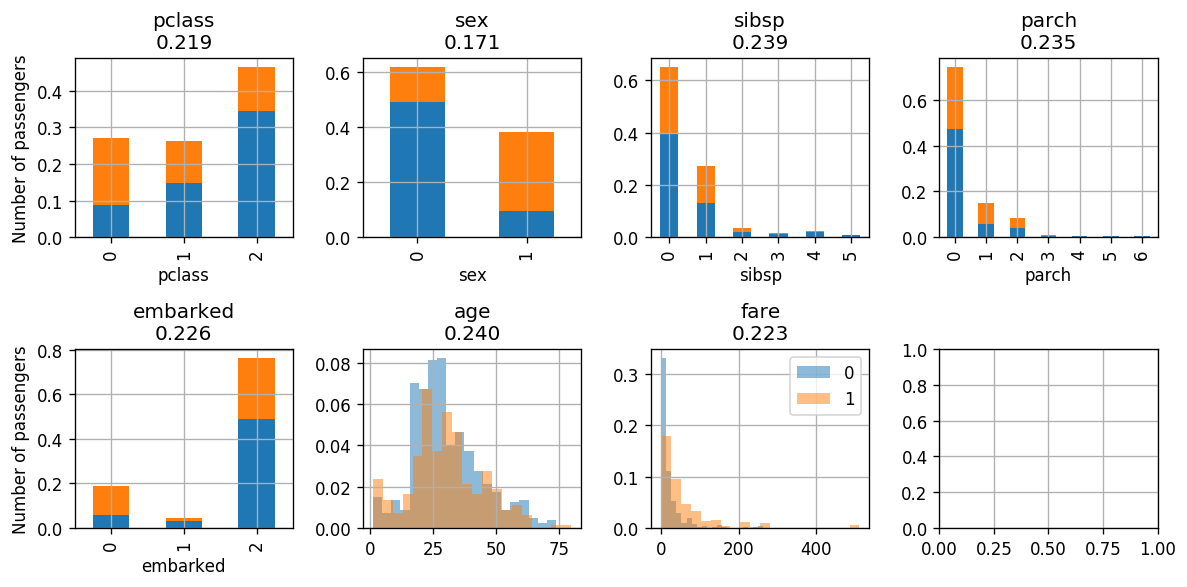

In [ ]:
adaboost.plot()
adaboost.dataset.head(10)

The Weighted Gini Indexes are plotted in the title. In each step we will select the feature with the lowest index. In this case this will be the **sex**.

#### Iteration: $t=1$

Classiffing according to the sex

Error: 0.22027534418022526
Alpha: 0.6320312618746508
Classifing sex according to: {0: [0], 1: [1]}


,age,embarked,fare,parch,pclass,sex,sibsp,survived,weights
724,11,2,46.9000,2,2,0,5,0,0.000803
77,27,2,30.5000,0,0,0,0,1,0.002841
879,6,2,21.0750,1,2,0,3,0,0.000803
615,22,2,7.2500,0,2,0,1,0,0.000803
905,24,2,8.6625,0,2,0,0,0,0.000803
533,42,2,7.5500,0,2,0,0,0,0.000803
401,50,2,13.0000,0,1,0,0,0,0.000803
454,39,2,26.0000,0,1,0,0,0,0.000803
31,58,2,26.5500,0,0,1,0,1,0.000803
358,18,2,13.0000,0,1,0,0,0,0.000803


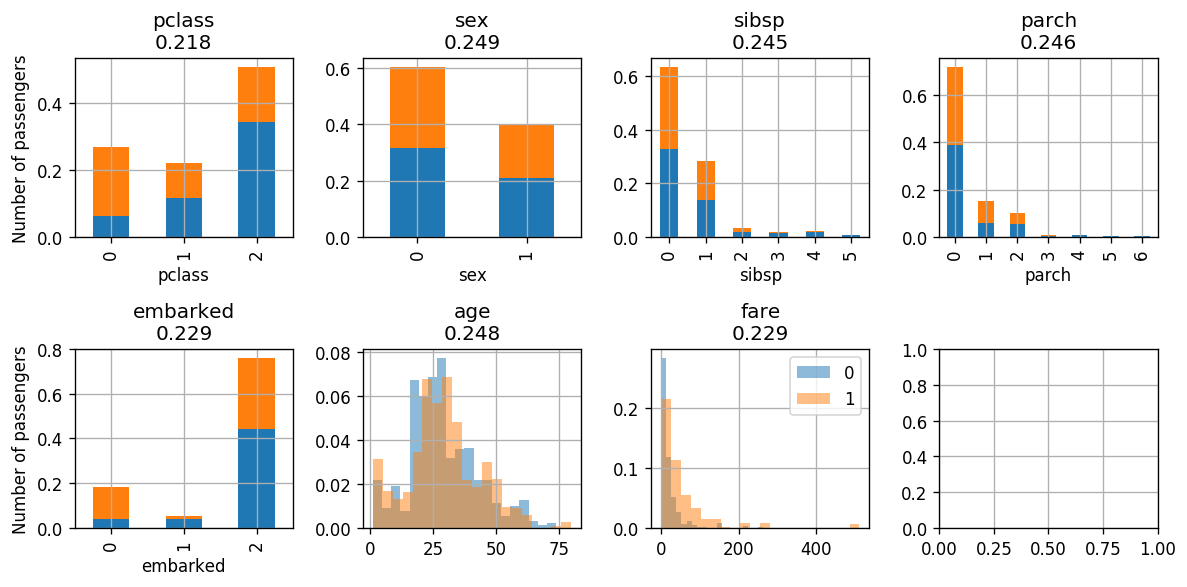

In [ ]:
adaboost.fit_step('sex')
adaboost.plot()
adaboost.dataset.head(10)

We will see that as we advance through the algorithm the weighted data becomes more uniformly distributed as a function of the labels, i.e. the distributions of the data with $y=1$ will be as the same as the distribution of the data with $y=-1$.

As a consequences of that, the classification task will become harder and the classifier's classification error will go to 0.5.

In addition the weighting parameter $\alpha_t$ will decrease over time.

Next we will classify according to the **pclass** which has the lowest index.

#### Iteration $T=2$

Error: 0.6677960382314314
Alpha: -0.3491168359813891
Classifing pclass according to: {0: [0], 1: [1, 2]}


,age,embarked,fare,parch,pclass,sex,sibsp,survived,weights
724,11,2,46.9000,2,2,0,5,0,0.000601
77,27,2,30.5000,0,0,0,0,1,0.002127
879,6,2,21.0750,1,2,0,3,0,0.000601
615,22,2,7.2500,0,2,0,1,0,0.000601
905,24,2,8.6625,0,2,0,0,0,0.000601
533,42,2,7.5500,0,2,0,0,0,0.000601
401,50,2,13.0000,0,1,0,0,0,0.000601
454,39,2,26.0000,0,1,0,0,0,0.000601
31,58,2,26.5500,0,0,1,0,1,0.000601
358,18,2,13.0000,0,1,0,0,0,0.000601


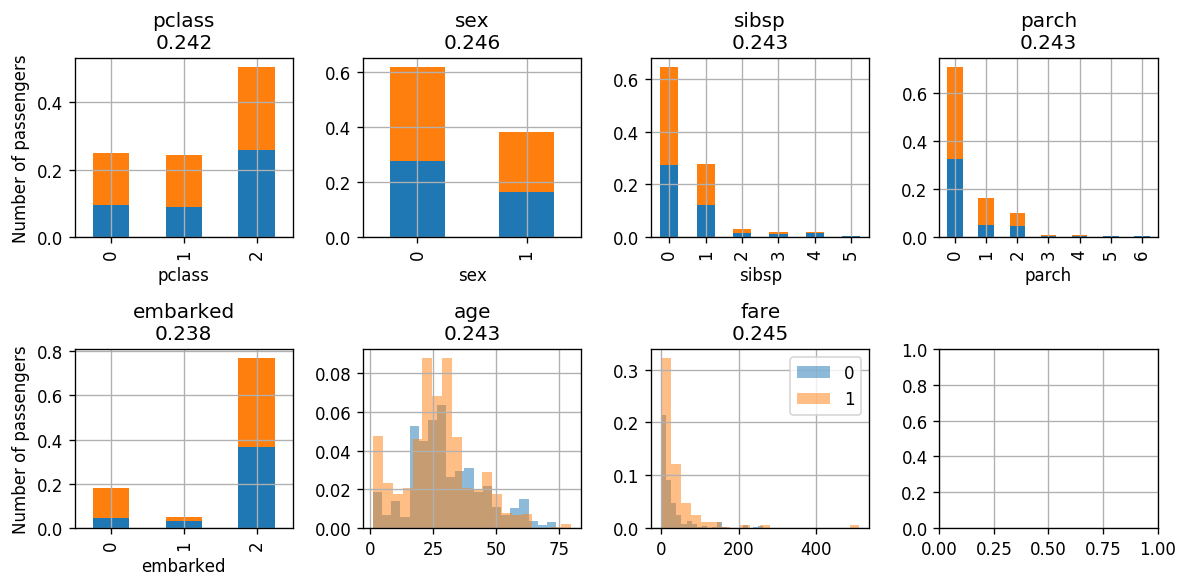

In [ ]:
adaboost.fit_step('pclass')
adaboost.plot()
adaboost.dataset.head(10)

Next we will classify according to the **embarked** which has the lowest index.

#### Iteration $T=3$

Error: 0.5323984758056922
Alpha: -0.06488786721923188
Classifing embarked according to: {0: [0], 1: [1, 2]}


,age,embarked,fare,parch,pclass,sex,sibsp,survived,weights
724,11,2,46.9000,2,2,0,5,0,0.000564
77,27,2,30.5000,0,0,0,0,1,0.002274
879,6,2,21.0750,1,2,0,3,0,0.000564
615,22,2,7.2500,0,2,0,1,0,0.000564
905,24,2,8.6625,0,2,0,0,0,0.000564
533,42,2,7.5500,0,2,0,0,0,0.000564
401,50,2,13.0000,0,1,0,0,0,0.000564
454,39,2,26.0000,0,1,0,0,0,0.000564
31,58,2,26.5500,0,0,1,0,1,0.000643
358,18,2,13.0000,0,1,0,0,0,0.000564


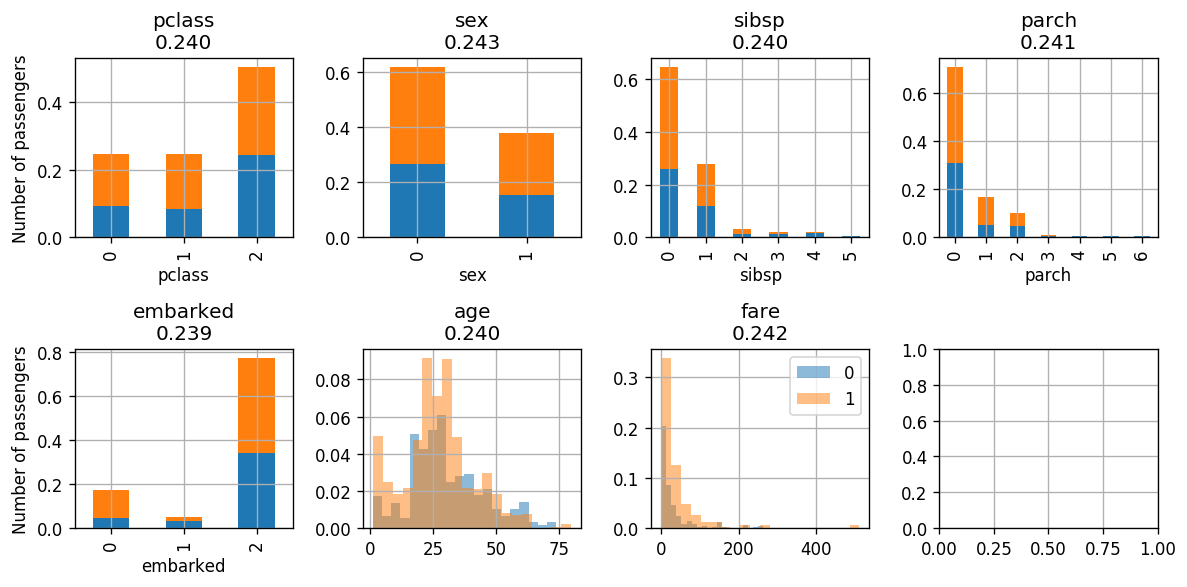

In [ ]:
adaboost.fit_step('embarked')
adaboost.plot()
adaboost.dataset.head(10)

Error: 0.5000000000000001
Alpha: -2.2204460492503136e-16
Classifing embarked according to: {0: [0], 1: [1, 2]}


,age,embarked,fare,parch,pclass,sex,sibsp,survived,weights
724,11,2,46.9000,2,2,0,5,0,0.000564
77,27,2,30.5000,0,0,0,0,1,0.002274
879,6,2,21.0750,1,2,0,3,0,0.000564
615,22,2,7.2500,0,2,0,1,0,0.000564
905,24,2,8.6625,0,2,0,0,0,0.000564
533,42,2,7.5500,0,2,0,0,0,0.000564
401,50,2,13.0000,0,1,0,0,0,0.000564
454,39,2,26.0000,0,1,0,0,0,0.000564
31,58,2,26.5500,0,0,1,0,1,0.000643
358,18,2,13.0000,0,1,0,0,0,0.000564


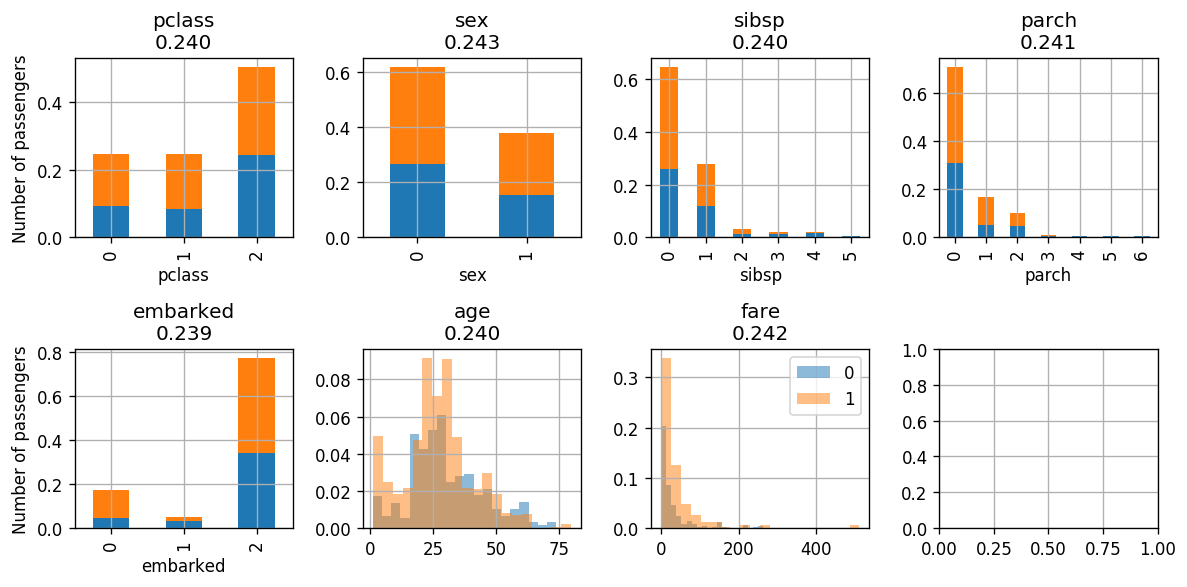

In [ ]:
adaboost.fit_step('embarked')
adaboost.plot()
adaboost.dataset.head(10)

We eventually reached a point where the classifier's classification error is very close to 0.5 and $alpha_t$ is very small.

## ⏱️ Performance evaluation

Let us calculate the risk on the test set

In [ ]:
x_train = train_set[discrete_columns + continuous_columns].values
y_train = train_set['survived'].values

x_test = test_set[discrete_columns + continuous_columns].values
y_test = test_set['survived'].values

In [ ]:
predictions = adaboost.predict(test_set)
# predictions = adaboost.stumps_list[0].predict(test_set)

test_risk = (y_test != predictions).mean()
print_math('The test risk is: ${:.3}$'.format(test_risk))

In [ ]:
%%html
<link rel="stylesheet" href="../css/style.css"> <!--Setting styles - You can simply ignore this line-->